In [1]:
import arviz as az
import pymc as pm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pytensor.tensor as pt
import celerite2
from celerite2.pymc import GaussianProcess, terms

# Toy dataset

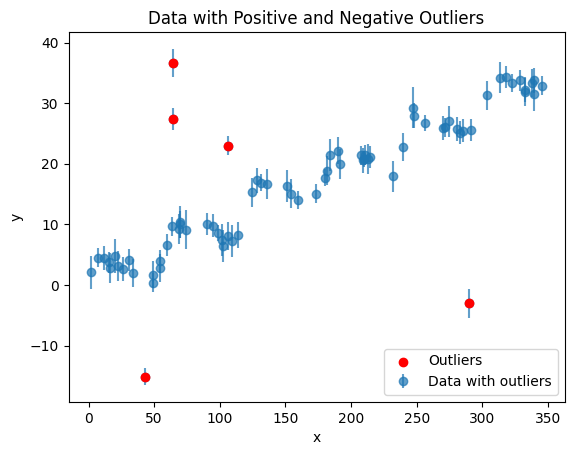

In [3]:
draws = 300
tune = 300

# Toy dataset
np.random.seed(42)
x = np.sort(np.random.uniform(0, 350, 75))
y = 3 * np.sin(x*np.pi*2/60.0) + np.random.normal(0, 1, size=len(x)) + 0.1 * x + 1 * np.sin(x*np.pi*2/30.0)
yerr = np.random.normal(2,0.5,75)
x_new = np.linspace(-20, 370, 100)

# plt.scatter(x, y, label="Data", zorder=100)
# plt.errorbar(x, y, yerr=yerr, fmt='o', alpha=0.7, label="Data")
# plt.xlabel("x")
# plt.ylabel("y")
# plt.legend()
# plt.show()

# Add outliers
num_outliers = 5
outlier_indices = np.random.choice(len(x), size=num_outliers, replace=False)

# Randomly decide if each outlier is positive or negative
outlier_signs = np.random.choice([-1, 1], size=num_outliers)

# Add large deviations (positive or negative) to the y values at these indices
y[outlier_indices] += outlier_signs * np.random.uniform(15, 30, size=num_outliers)

# Plot the data
plt.errorbar(x, y, yerr=yerr, fmt="o", label="Data with outliers", alpha=0.7)
plt.scatter(x[outlier_indices], y[outlier_indices], color="red", label="Outliers", zorder=5)
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.title("Data with Positive and Negative Outliers")
plt.show()

# No GP

In [3]:
with pm.Model() as model_no_gp:
    # Priors
    intercept = pm.Normal("intercept", mu=0, sigma=10)
    slope = pm.Normal("slope", mu=0, sigma=10)
    sigma = pm.Uniform("sigma", lower=0, upper=10)

    # Linear model
    mu = intercept + slope * x
    y_pred = pm.Deterministic("predicted", mu)
    
    # Likelihood
    y_obs = pm.Normal("y_obs", mu=mu, sigma=pt.sqrt(yerr**2 + sigma**2), observed=y)	

    # Sample
    trace_no_gp = pm.sample(draws=draws, tune=tune, chains=2, return_inferencedata=True)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [intercept, slope, sigma]


Output()

Sampling 2 chains for 300 tune and 300 draw iterations (600 + 600 draws total) took 3 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


In [4]:
pm.compute_log_likelihood(trace_no_gp, model=model_no_gp)

Output()

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

In [5]:
loo_nogp = az.loo(trace_no_gp)

/home/juan/anaconda3/envs/exoplanet3/lib/python3.11/site-packages/arviz/stats/stats.py:797: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.64 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


In [6]:
loo_nogp

Computed from 600 posterior samples and 75 observations log-likelihood matrix.

         Estimate       SE
elpd_loo  -253.23    17.69
p_loo        8.49        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.64]   (good)       73   97.3%
   (0.64, 1]   (bad)         2    2.7%
   (1, Inf)   (very bad)    0    0.0%

In [7]:
flat = trace_no_gp.posterior.stack(draws=("chain", "draw"))
linear_trend = flat["predicted"].median(axis=-1)

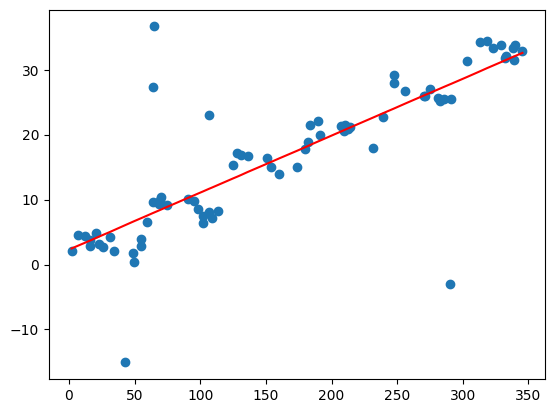

In [8]:
# plot the model
plt.plot(x, y, "o", label="Data with outliers")
plt.plot(x, linear_trend, "r", label="Linear trend")

# celerite2 GP SHO kernel

In [ ]:
with pm.Model() as model_celerite_sho:
    # Priors
    intercept = pm.Normal("intercept", mu=0, sigma=10)
    slope = pm.Normal("slope", mu=0, sigma=10)
    sigma = pm.Uniform("sigma", lower=0, upper=10)

    def linear_trend(x):
        return intercept + slope * x
    trend = pm.Deterministic("linear_trend", linear_trend(x))

    # Noise model parameters
    sigma_gp = pm.HalfNormal("sigma_gp", sigma=np.std(y))
    rho_gp = pm.Uniform("rho_gp", lower=0, upper=100)
    kernel = terms.SHOTerm(
        sigma=sigma_gp, 
        rho=rho_gp, 
        Q=1.0 / 3)
    
    gp = GaussianProcess(kernel, t=x, mean=linear_trend, yerr=pt.sqrt(yerr**2 + sigma**2))
    gp.marginal("obs", observed=y)
    pm.Deterministic("y_pred", gp.predict(y, include_mean=True))
    
    # map = pm.find_MAP()
    trace_celerite_sho = pm.sample(draws=draws, tune=tune, chains=2, return_inferencedata=True)

/home/juan/anaconda3/envs/exoplanet3/lib/python3.11/site-packages/pytensor/tensor/random/op.py:83: FutureWarning: ndim_supp is deprecated. Provide signature instead.
  warnings.warn(
/home/juan/anaconda3/envs/exoplanet3/lib/python3.11/site-packages/pytensor/tensor/random/op.py:93: FutureWarning: ndims_params is deprecated. Provide signature instead.
  warnings.warn(
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [intercept, slope, sigma, rho_gp]


Output()

Sampling 2 chains for 300 tune and 300 draw iterations (600 + 600 draws total) took 3 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


In [21]:
pm.compute_log_likelihood(trace_celerite_sho, model=model_celerite_sho)

Output()

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

In [22]:
var_names = ["intercept", "slope", "sigma", "sigma_gp", "rho_gp"]
az.summary(trace_celerite_sho, var_names=var_names)

KeyError: 'var names: "[\'sigma_gp\'] are not present" in dataset'

In [23]:
az.loo(trace_celerite_sho)

/home/juan/anaconda3/envs/exoplanet3/lib/python3.11/site-packages/arviz/stats/stats.py:797: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.64 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/home/juan/anaconda3/envs/exoplanet3/lib/python3.11/site-packages/arviz/stats/stats.py:840: UserWarning: The point-wise LOO is the same with the sum LOO, please double check the Observed RV in your model to make sure it returns element-wise logp.
  warnings.warn(


Computed from 600 posterior samples and 1.0 observations log-likelihood matrix.

         Estimate       SE
elpd_loo  -249.92     0.00
p_loo        2.06        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.64]   (good)        0    0.0%
   (0.64, 1]   (bad)         1  100.0%
   (1, Inf)   (very bad)    0    0.0%

In [24]:
az.plot_trace(trace_celerite_sho, var_names=var_names)
plt.subplots_adjust(hspace=0.5)
plt.show()

KeyError: 'var names: "[\'sigma_gp\'] are not present" in dataset'

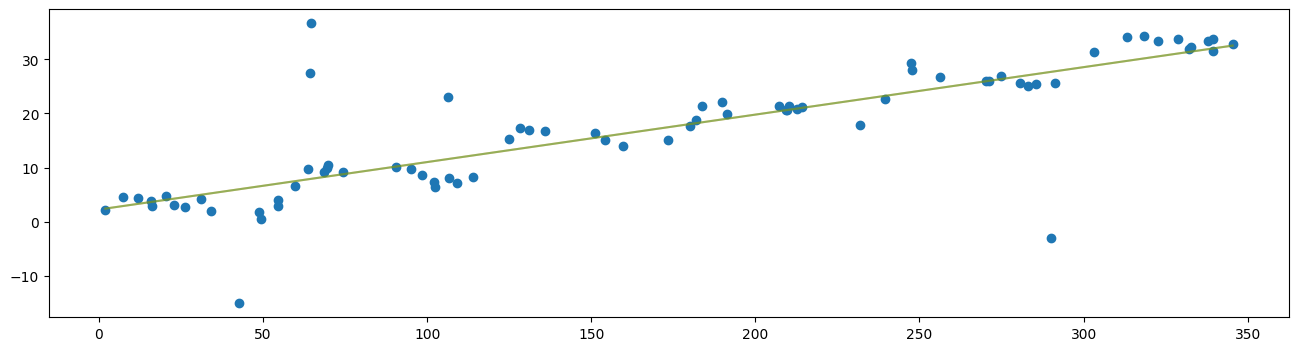

In [ ]:
plt.subplots(figsize=(16, 4))
plt.plot(x,y, "o", label="Data")
plt.plot(x, trace_celerite_sho.posterior["y_pred"].mean(dim=["chain", "draw"]), label="Celerite sho", alpha=0.5)
plt.fill_between(
    x,
    trace_celerite_sho.posterior["y_pred"].quantile(0.05, dim=["chain", "draw"]),
    trace_celerite_sho.posterior["y_pred"].quantile(0.95, dim=["chain", "draw"]),
    alpha=0.5,
    label="95% CI",
);

In [18]:
# posterior predictions should be made using predict with a deterministic variable at new points inside the model
# and then plot the predictions as a postprocessing step

# with model_celerite_sho:
#     y_pred_new = gp.conditional("y_pred_new", x_new, pred_noise=True)
#     y_samples = pm.sample_posterior_predictive(
#         trace_celerite_sho.sel(draw=slice(0, 50)), var_names=["y_pred_new"]
#     )

# Manual LOO for SHO

In [15]:
sigma_ = trace_celerite_sho.posterior["sigma"].stack(draws=("chain", "draw")).median().values
sigma_gp_ = trace_celerite_sho.posterior["sigma_gp"].stack(draws=("chain", "draw")).median().values
rho_gp_ = trace_celerite_sho.posterior["rho_gp"].stack(draws=("chain", "draw")).median().values
intercept_ = trace_celerite_sho.posterior["intercept"].stack(draws=("chain", "draw")).median().values
slope_ = trace_celerite_sho.posterior["slope"].stack(draws=("chain", "draw")).median().values
linear_trend_ = trace_celerite_sho.posterior["linear_trend"].stack(draws=("chain", "draw")).median(axis=-1).values
y_ = y - linear_trend_
# print(sigma_, sigma_gp_, rho_gp_, y_)

In [16]:
diag_ = yerr**2+sigma_**2

In [17]:
from utils import loo_cv
loo_celerite_sho = loo_cv(x=x, y=y_, diag=diag_, sigma=sigma_gp_, term="sho", rho=rho_gp_, verbose=False)
print("LOO from median:", loo_celerite_sho[0])
print("LOO std from median:", loo_celerite_sho[1])

LOO from median: -300.91527134996346
LOO std from median: 61.636653469702644


In [17]:
flat_samps = trace_celerite_sho.posterior.stack(draws=("chain", "draw"))

In [ ]:
# LOOs = []
# LOOs_std = []
# for i in range(len(flat_samps["sigma"].values)):
#     diag_ = yerr**2+flat_samps["sigma"][i].values**2
#     sigma_gp_ = flat_samps["sigma_gp"][i].values
#     rho_gp_ = flat_samps["rho_gp"][i].values
#     linear_trend = flat_samps["linear_trend"][:, i].values
#     loo, loo_se = loo_cv(x=x, y=y - linear_trend, diag=diag_, sigma=sigma_gp_, term="sho", rho=rho_gp_, verbose=False)
#     LOOs.append(loo)
#     LOOs_std.append(loo_se)

# LOOs = np.array(LOOs)

In [19]:
# print("LOO from full-posterior:", np.median(LOOs))
# print("LOO std from full-posterior:", np.std(LOOs))

# not much difference but is different

LOO from full-posterior: -147.88355445337075
LOO std from full-posterior: 1.6380189462390584


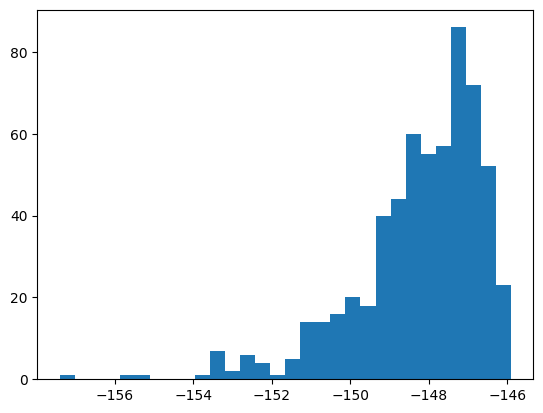

In [21]:
# plt.hist(LOOs, bins=30);

# Likelihood function

In [22]:
from utils import log_likelihood 

# this is the same as the compute_log_likelihood method of pymc
# eq. 5.8 of Rasmussen and Williams, "marginal likelihood", marginal because it is marginalized over the GP hyperparameters

f_likelihood = log_likelihood(x=x, y=y_, diag=diag_, sigma=sigma_gp_, term="sho", rho=rho_gp_)
print("Likelihood:", f_likelihood)

Likelihood: -163.7271000685927


In [ ]:
# full_L = []
# full_L_std = []
# for i in range(len(flat_samps["sigma"].values)):
#     diag_ = yerr**2+flat_samps["sigma"][i].values**2
#     sigma_gp_ = flat_samps["sigma_gp"][i].values
#     rho_gp_ = flat_samps["rho_gp"][i].values
#     linear_trend = flat_samps["linear_trend"][:, i].values
#     full_L.append(likelihood(x=x, y=y - linear_trend, diag=diag_, sigma=sigma_gp_, term="sho", rho=rho_gp_))

# full_L = np.array(full_L)

In [ ]:
# print("median full_L:", np.median(full_L))
# print("std full_L:", np.std(full_L))
# plt.hist(full_L, bins=50);

In [ ]:
# plt.hist(trace_celerite_sho.log_likelihood['obs'].stack(draws=("chain", "draw")).values, bins=50);

# Celerite GP QP kernel

In [19]:
from celerite2.pymc import GaussianProcess, terms
import pymc_ext as pmx

with pm.Model() as model_celerite_qp:
    # Priors
    intercept = pm.Normal("intercept", mu=0, sigma=10)
    slope = pm.Normal("slope", mu=0, sigma=10)
    sigma = pm.Uniform("sigma", lower=0, upper=10)

    def linear_trend(x):
        return intercept + slope * x
    trend = pm.Deterministic("linear_trend", linear_trend(x))

    sigma_gp = pm.HalfNormal("sigma_gp", sigma=np.std(y))
    # gp_period = pm.Uniform("gp_period", lower=0.0, upper=100.0)
    # Q0 = pm.Uniform("Q0", lower=3.14, upper=100.0)
    # dQ = pm.Uniform("dQ", lower=0.001, upper=100.0)
    # f = pm.Uniform("f", lower=0.0, upper=1.0)
    kernelrv = terms.RotationTerm(
        sigma=sigma_gp,
        period=60.0,
        Q0=1000,
        dQ=900,
        f=0.5)

    
    gp = GaussianProcess(kernelrv, t=x, mean=trend, yerr=pt.sqrt(yerr**2 + sigma**2))
    gp.marginal("obs", observed=y)

    pm.Deterministic("y_pred", gp.predict(y, include_mean=True))

    # Sample
    trace_celerite_qp = pm.sample(draws=draws, tune=tune, chains=2, return_inferencedata=True)

/home/juan/anaconda3/envs/exoplanet3/lib/python3.11/site-packages/pytensor/tensor/random/op.py:83: FutureWarning: ndim_supp is deprecated. Provide signature instead.
  warnings.warn(
/home/juan/anaconda3/envs/exoplanet3/lib/python3.11/site-packages/pytensor/tensor/random/op.py:93: FutureWarning: ndims_params is deprecated. Provide signature instead.
  warnings.warn(
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [intercept, slope, sigma, sigma_gp]


Output()

Sampling 2 chains for 300 tune and 300 draw iterations (600 + 600 draws total) took 3 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


In [5]:
var_names = ["intercept", "slope", "sigma", "sigma_gp", "gp_period", "Q0", "dQ", "f"]
az.summary(trace_celerite_qp, var_names=var_names)

KeyError: 'var names: "[\'gp_period\' \'Q0\' \'dQ\' \'f\'] are not present" in dataset'

In [20]:
pm.compute_log_likelihood(trace_celerite_qp, model=model_celerite_qp)

Output()

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

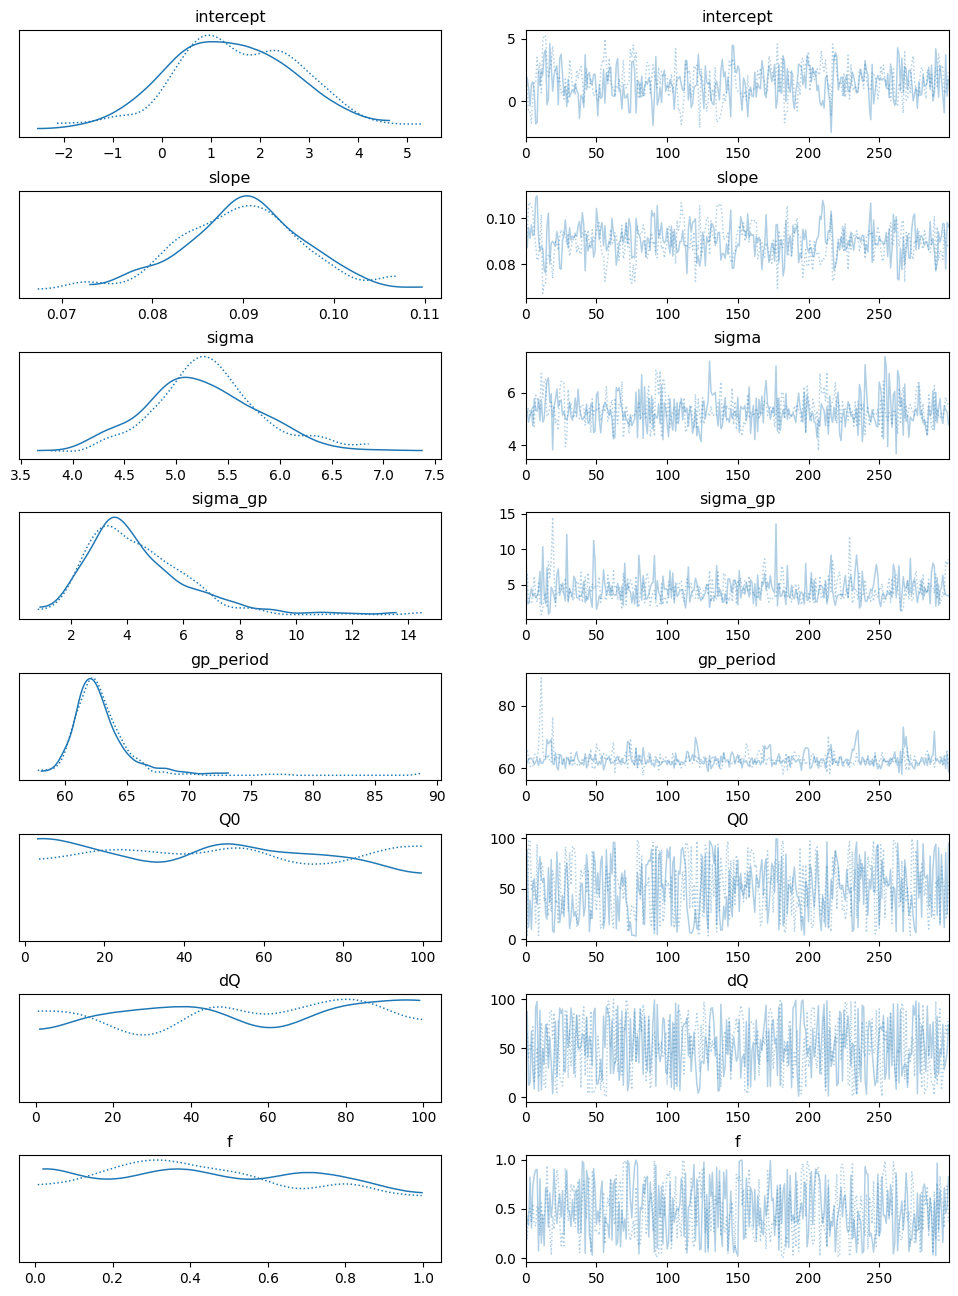

In [21]:
az.plot_trace(trace_celerite_qp, var_names=var_names)
plt.subplots_adjust(hspace=0.5)
plt.show()

In [22]:
az.loo(trace_celerite_qp)

/home/juan/anaconda3/envs/exoplanet3/lib/python3.11/site-packages/arviz/stats/stats.py:797: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.64 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/home/juan/anaconda3/envs/exoplanet3/lib/python3.11/site-packages/arviz/stats/stats.py:840: UserWarning: The point-wise LOO is the same with the sum LOO, please double check the Observed RV in your model to make sure it returns element-wise logp.
  warnings.warn(


Computed from 600 posterior samples and 1.0 observations log-likelihood matrix.

         Estimate       SE
elpd_loo  -245.07     0.00
p_loo        4.08        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.64]   (good)        0    0.0%
   (0.64, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    1  100.0%

In [23]:
sigma_ = trace_celerite_qp.posterior["sigma"].stack(draws=("chain", "draw")).median().values
sigma_gp_ = trace_celerite_qp.posterior["sigma_gp"].stack(draws=("chain", "draw")).median().values
period_ = trace_celerite_qp.posterior["gp_period"].stack(draws=("chain", "draw")).median().values
Q0_ = trace_celerite_qp.posterior["Q0"].stack(draws=("chain", "draw")).median().values
dQ_ = trace_celerite_qp.posterior["dQ"].stack(draws=("chain", "draw")).median().values
f_ = trace_celerite_qp.posterior["f"].stack(draws=("chain", "draw")).median().values
linear_trend_ = trace_celerite_qp.posterior["linear_trend"].stack(draws=("chain", "draw")).median(axis=-1).values
y_ = y - linear_trend_
diag_ = yerr**2+sigma_**2

In [75]:
loo_celerite_qp =  loo_cv(x=x, y=y_, diag=diag_, sigma=sigma_gp_, term="rotation", Q0=Q0_, dQ=dQ_, f=f_, period=period_, verbose=False)
loo_celerite_qp

(-556.0654229010103, 194.2911172809363)

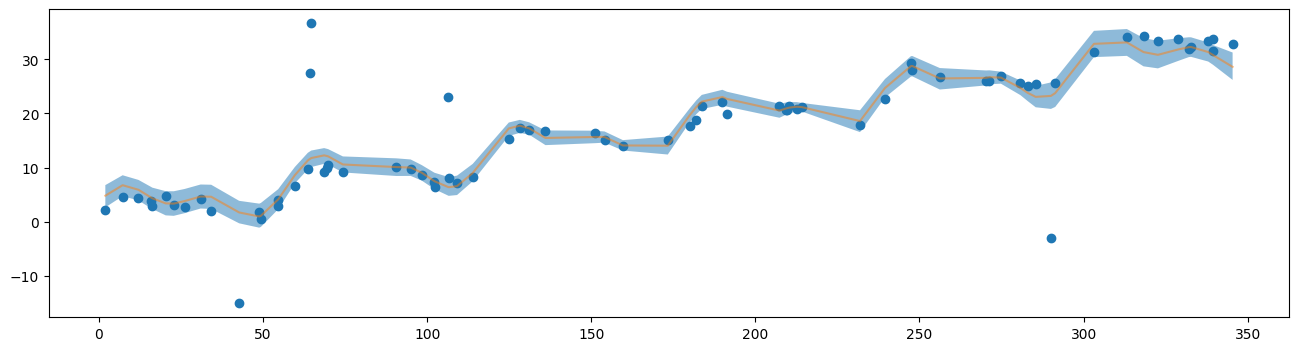

In [20]:
plt.subplots(figsize=(16, 4))
plt.plot(x,y, "o", label="Data")
plt.plot(x, trace_celerite_qp.posterior["y_pred"].mean(dim=["chain", "draw"]), label="Celerite sho", alpha=0.5)
plt.fill_between(
    x,
    trace_celerite_qp.posterior["y_pred"].quantile(0.05, dim=["chain", "draw"]),
    trace_celerite_qp.posterior["y_pred"].quantile(0.95, dim=["chain", "draw"]),
    alpha=0.5,
    label="95% CI",
);

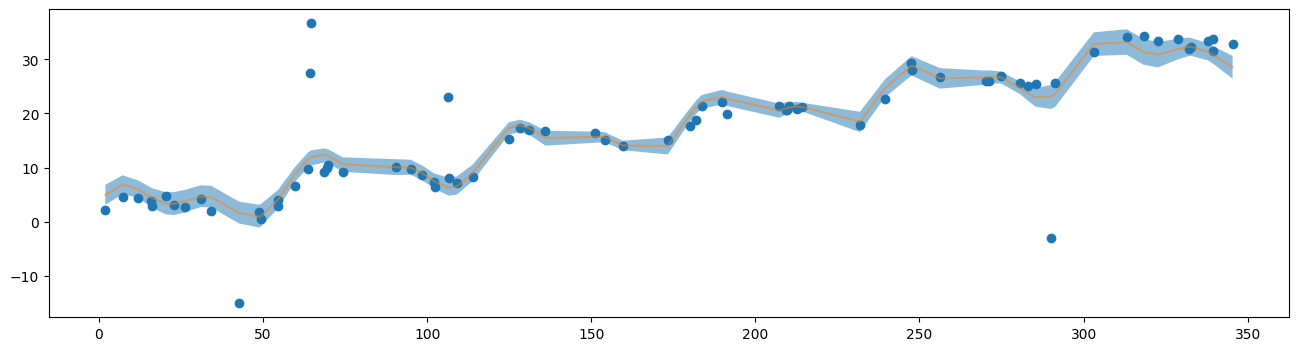

In [18]:
plt.subplots(figsize=(16, 4))
plt.plot(x,y, "o", label="Data")
plt.plot(x, trace_celerite_qp.posterior["y_pred"].mean(dim=["chain", "draw"]), label="Celerite sho", alpha=0.5)
plt.fill_between(
    x,
    trace_celerite_qp.posterior["y_pred"].quantile(0.05, dim=["chain", "draw"]),
    trace_celerite_qp.posterior["y_pred"].quantile(0.95, dim=["chain", "draw"]),
    alpha=0.5,
    label="95% CI",
);

# Plot compare

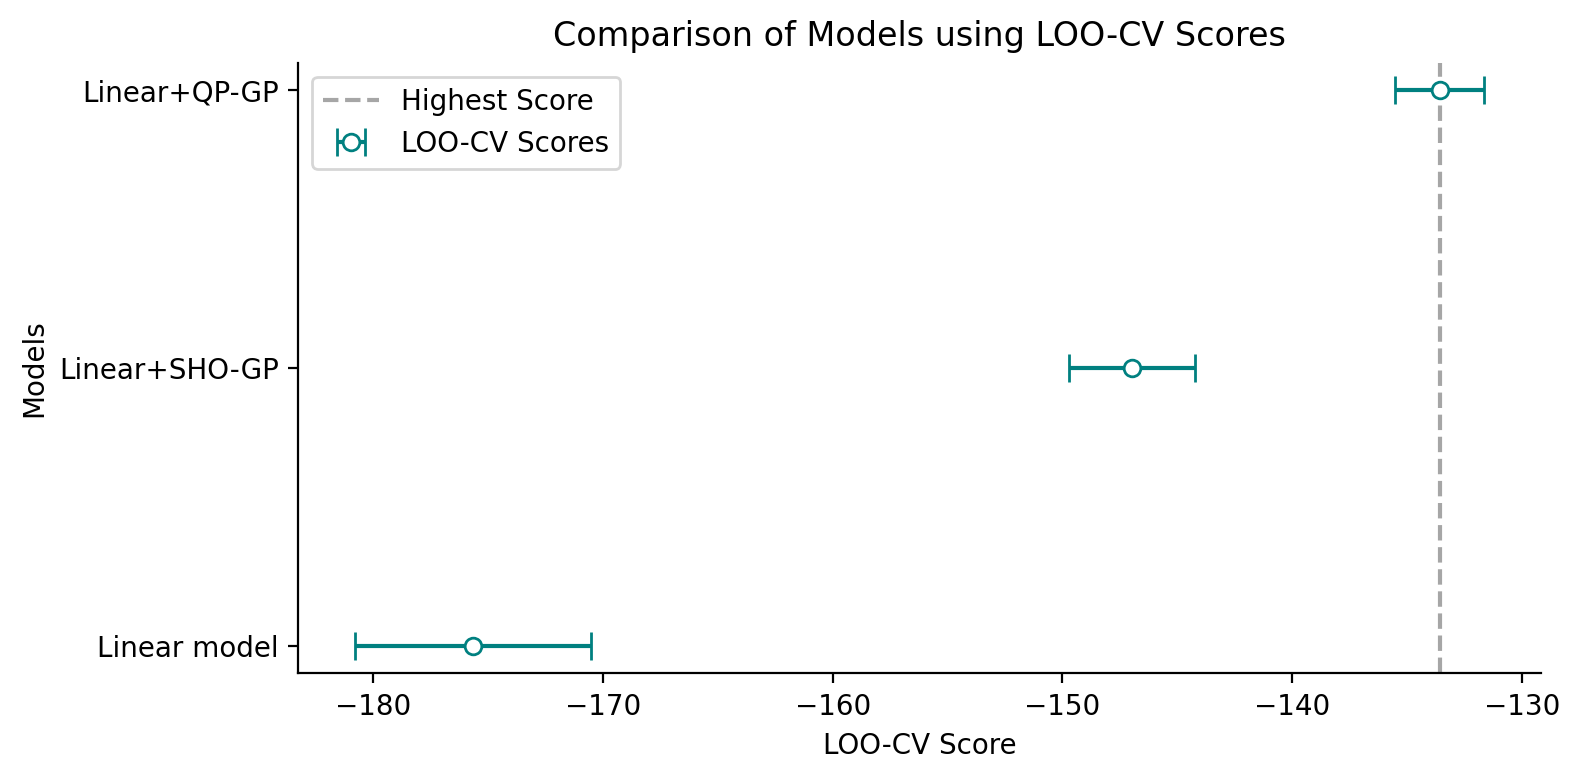

In [31]:
# Model names, LOO-CV scores, and standard errors
import matplotlib.pyplot as plt
import numpy as np

models = ["Linear model", "Linear+SHO-GP", "Linear+QP-GP"]
loo_scores = [loo_nogp.elpd_loo, loo_celerite_sho[0], loo_celerite_qp[0]]
loo_se = [loo_nogp.se, loo_celerite_sho[1], loo_celerite_qp[1]]
y_positions = np.arange(len(models))
max_loo_score = max(loo_scores)

plt.figure(figsize=(8, 4), dpi=200)
plt.errorbar(loo_scores, y_positions, xerr=loo_se, fmt='o', capsize=5, markerfacecolor='white', markeredgecolor='teal', color='teal', label="LOO-CV Scores")
plt.axvline(max_loo_score, color='gray', linestyle='--', alpha=0.7, label="Highest Score")
plt.yticks(y_positions, models)
plt.xlabel("LOO-CV Score")
plt.ylabel("Models")
plt.title("Comparison of Models using LOO-CV Scores")
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.grid(False)
plt.legend()
plt.tight_layout()
plt.show()


# Pymc latent with celerite2 SHO

In [ ]:
from pytensor.tensor.linalg import cholesky, solve, solve_triangular
from pymc.gp.util import (JITTER_DEFAULT,stabilize)
from pymc.gp.mean import Zero
from functools import partial

solve_lower = partial(solve_triangular, lower=True)

with pm.Model() as model_latent_sho:
    intercept = pm.Normal("intercept", mu=0, sigma=10)
    slope = pm.Normal("slope", mu=0, sigma=10)
    sigma = pm.Uniform("sigma", lower=0, upper=10)
    # Linear trend
    def linear_trend(x):
        return intercept + slope * x
    trend = pm.Deterministic("linear_trend", linear_trend(x))

    sigma_gp = pm.HalfNormal("sigma_gp", sigma=np.std(y))
    rho_gp = pm.Uniform("rho_gp", lower=0, upper=50)
    
    # celerite2 kernel
    kernel = terms.SHOTerm(
        sigma=sigma_gp, 
        rho=rho_gp, 
        Q=1.0 / 3
    )

    matrix = x[:, None] - x[None, :] # Lag matrix
    raw_cov = kernel.get_value(matrix) # Covariance matrix, evaluate the kernel on the lag matrix
    cov = stabilize(raw_cov, JITTER_DEFAULT) # Add jitter to stabilize for cholesky decomp
    #mu = Zero()(x)  # Zero mean function
    chol = cholesky(cov) # Cholesky decomposition X = L L^T
    v = pm.Normal("gp_rotated", mu=0.0, sigma=1.0, size=x.shape[0]) # Reparametrization trick, sample v and then rotate by L
    f_gp = trend + chol.dot(v.T).transpose() # f_gp is a draw from the multivariate normal with mean mu and covariance cov – exactly the GP prior over x 
    
    # if reparameterize is False, use this instead. dont need to cholesky decomp
    #f_gp = pm.MvNormal(name, mu=mu, cov=cov, shape=x.shape[0])

    y_obs = pm.Normal("y_obs", mu=f_gp, sigma=pt.sqrt(yerr**2 + sigma**2), observed=y)
    pm.Deterministic("y_pred", f_gp)

    # Kxx = kernel.get_value(matrix)
    # Kxs = kernel.get_value(x[:, None] - x_new[None, :])
    # L = cholesky(stabilize(Kxx, JITTER_DEFAULT))
    # A = solve_lower(L, Kxs)
    # v_ = solve_lower(L, (y - Zero()(x)).T)
    # mu_ = Zero()(x_new) + pt.dot(pt.transpose(A), v_).T
    # Kss = kernel.get_value(x_new[:, None] - x_new[None, :])
    # cov_ = Kss - pt.dot(pt.transpose(A), A)
    # f_new = pm.MvNormal("f_new", mu=mu_, cov=cov_)

    # Sampling
    trace_latent_sho = pm.sample(draws=draws, tune=tune, chains=2, return_inferencedata=True)

In [ ]:
# # Generate predictions
# with model_latent_sho:
#     posterior_predictive = pm.sample_posterior_predictive(trace_latent_sho, var_names=["f_new"])

In [ ]:
# def conditional(self, name, Xnew, given=None, jitter=JITTER_DEFAULT, **kwargs):
#     R"""
#     Return the conditional distribution evaluated over new input locations `Xnew`.

#     Given a set of function values `f` that
#     the GP prior was over, the conditional distribution over a
#     set of new points, `f_*` is

#     .. math::

#         f_* \mid f, X, X_* \sim \mathcal{GP}\left(
#             K(X_*, X) K(X, X)^{-1} f \,,
#             K(X_*, X_*) - K(X_*, X) K(X, X)^{-1} K(X, X_*) \right)

#     Parameters
#     ----------
#     name : str
#         Name of the random variable
#     Xnew : array-like
#         Function input values. If one-dimensional, must be a column
#         vector with shape `(n, 1)`.
#     given : dict, optional
#         Can take as key value pairs: `X`, `y`,
#         and `gp`. See the :ref:`section <additive_gp>` in the documentation
#         on additive GP models in pymc for more information.
#     jitter : float, default 1e-6
#         A small correction added to the diagonal of positive semi-definite
#         covariance matrices to ensure numerical stability.
#     **kwargs
#         Extra keyword arguments that are passed to :class:`~pymc.MvNormal` distribution
#         constructor.
#     """
#     givens = self._get_given_vals(given)
#     mu, cov = self._build_conditional(Xnew, *givens, jitter)
#     f = pm.MvNormal(name, mu=mu, cov=cov, **kwargs)

#     return f

In [ ]:
# def _build_conditional(self, Xnew, X, f, cov_total, mean_total, jitter):
#     Kxx = cov_total(X)
#     Kxs = self.cov_func(X, Xnew)

#     L = cholesky(stabilize(Kxx, jitter))
#     A = solve_lower(L, Kxs)
#     v = solve_lower(L, (f - mean_total(X)).T)

#     mu = self.mean_func(Xnew) + pt.dot(pt.transpose(A), v).T

#     Kss = self.cov_func(Xnew)
#     cov = Kss - pt.dot(pt.transpose(A), A)

#     return mu, cov

In [ ]:
# def _get_given_vals(self, given):
#     if given is None:
#         given = {}

#     if "gp" in given:
#         cov_total = given["gp"].cov_func
#         mean_total = given["gp"].mean_func
#     else:
#         cov_total = self.cov_func
#         mean_total = self.mean_func

#     if "noise" in given:
#         warnings.warn(_noise_deprecation_warning, FutureWarning)
#         given["sigma"] = given["noise"]

#     if all(val in given for val in ["X", "y", "sigma"]):
#         X, y, sigma = given["X"], given["y"], given["sigma"]
#         noise_func = sigma if isinstance(sigma, BaseCovariance) else pm.gp.cov.WhiteNoise(sigma)
#     else:
#         X, y, noise_func = self.X, self.y, self.sigma
#     return X, y, noise_func, cov_total, mean_total

In [ ]:
var_names = ["intercept", "slope", "sigma", "sigma_gp", "rho_gp"]
az.summary(trace_latent_sho , var_names=var_names)

In [ ]:
pm.compute_log_likelihood(trace_latent_sho , model=model_latent_sho)

In [ ]:
az.loo(trace_latent_sho)

In [ ]:
f_post = az.extract(trace_latent_sho, var_names="y_pred").transpose("sample", ...)
f_post

In [ ]:
fig, ax = plt.subplots(figsize=(16, 4))

from pymc.gp.util import plot_gp_dist
f_post = az.extract(trace_latent_sho, var_names="y_pred").transpose("sample", ...)
plot_gp_dist(ax, f_post, x)

plt.plot(x,y, "o", label="Data")
# plt.plot(x_new, posterior_predictive.posterior_predictive["f_new"].median(dim=["chain", "draw"]).values, label="Latent GP", alpha=0.5)
# plt.fill_between(
#     x_new,
#     posterior_predictive.posterior_predictive["f_new"].quantile(0.16, dim=["chain", "draw"]),
#     posterior_predictive.posterior_predictive["f_new"].quantile(0.84, dim=["chain", "draw"]),
#     alpha=0.5,
#     label="95% CI",
# );
# plt.plot(x, trace_latent_sho.posterior["y_pred"].mean(dim=["chain", "draw"]), label="No GP", alpha=0.5)
# plt.fill_between(
#    x,
#    trace_latent_sho.posterior["y_pred"].quantile(0.05, dim=["chain", "draw"]),
#    trace_latent_sho.posterior["y_pred"].quantile(0.95, dim=["chain", "draw"]),
#    alpha=0.5,
#    label="95% CI",
# );

In [ ]:
az.plot_trace(trace_latent_sho, var_names=var_names)
plt.subplots_adjust(hspace=0.5)

# Pymc Latent with celerite2 QP

In [ ]:
from pytensor.tensor.linalg import cholesky
from pymc.gp.util import (JITTER_DEFAULT,stabilize)
from pymc.gp.mean import Zero
import exoplanet as xo

with pm.Model() as model_latent_qp:
    intercept = pm.Normal("intercept", mu=0, sigma=10)
    slope = pm.Normal("slope", mu=0, sigma=10)
    sigma = pm.Uniform("sigma", lower=0, upper=10)
    # Linear trend
    def linear_trend(x):
        return intercept + slope * x
    trend = pm.Deterministic("linear_trend", linear_trend(x))

    sigma_gp = pm.HalfNormal("sigma_gp", sigma=np.std(y))
    gp_period = pm.Uniform("gp_period", lower=0.0, upper=100.0)
    Q0 = pm.Uniform("Q0", lower=3.14, upper=100.0)
    dQ = pm.Uniform("dQ", lower=0.001, upper=100.0)
    f = pm.Uniform("f", lower=0.0, upper=1.0)

    kernel = terms.RotationTerm(
        sigma=sigma_gp,
        period=gp_period,
        Q0=Q0,
        dQ=dQ,
        f=f)

    # Covariance matrix and stabilization
    matrix = x[:, None] - x[None, :]
    raw_cov = kernel.get_value(matrix)
    cov = stabilize(raw_cov, JITTER_DEFAULT)
    mu = Zero()(x)  
    chol = cholesky(cov)
    v = pm.Normal("gp_rotated", mu=0.0, sigma=1.0, size=x.shape[0])
    f_gp = mu + chol.dot(v.T).transpose()

    # Likelihood
    y_obs = pm.Normal("y_obs", mu=trend + f_gp, sigma=pt.sqrt(yerr**2 + sigma**2), observed=y)
    pm.Deterministic("y_pred", f_gp + trend)

    # Sampling
    trace_latent_qp = pm.sample(draws=draws, tune=tune, chains=2, return_inferencedata=True)

In [ ]:
var_names = ["intercept", "slope", "sigma", "sigma_gp", "gp_period", "Q0", "dQ", "f"]
az.summary(trace_latent_qp , var_names=var_names)

In [ ]:
pm.compute_log_likelihood(trace_latent_qp , model=model_latent_qp)

In [ ]:
az.loo(trace_latent_qp)

In [ ]:
plt.subplots(figsize=(16, 4))
plt.plot(x,y, "o", label="Data")
plt.plot(x, trace_latent_qp.posterior["y_pred"].mean(dim=["chain", "draw"]), label="No GP", alpha=0.5)
plt.fill_between(
    x,
    trace_latent_qp.posterior["y_pred"].quantile(0.05, dim=["chain", "draw"]),
    trace_latent_qp.posterior["y_pred"].quantile(0.95, dim=["chain", "draw"]),
    alpha=0.5,
    label="95% CI",
);

In [ ]:
az.plot_trace(trace_latent_qp, var_names=var_names)
plt.subplots_adjust(hspace=0.5);

# Latent SHO implementation?

In [ ]:
# Define the model
with pm.Model() as model_latent_pymc:
    intercept = pm.Normal("intercept", mu=0, sigma=10)
    slope = pm.Normal("slope", mu=0, sigma=10)
    sigma = pm.Uniform("sigma", lower=0, upper=10)
    # Linear trend
    def linear_trend(x):
        return intercept + slope * x
    trend = pm.Deterministic("linear_trend", linear_trend(x))

    sigma_gp = pm.HalfNormal("sigma_gp", sigma=np.std(y))  # Amplitude
    decay = pm.Uniform("decay", lower=0, upper=100)  # Damping (length scale of envelope)
    period = pm.Uniform("period", lower=0.0, upper=100.0)  # Oscillation period

    # Define the SHO kernel:
    # 1. Cosine kernel for oscillatory behavior
    cosine_kernel = pm.gp.cov.Cosine(1, ls=period)

    # 2. Exponentially decaying envelope
    decay_kernel = pm.gp.cov.ExpQuad(1, ls=decay)

    # 3. Combine kernels
    sho_kernel = sigma_gp**2 * cosine_kernel * decay_kernel

    # Latent GP
    gp = pm.gp.Latent(cov_func=sho_kernel)
    f_gp = gp.prior("f_gp", X=x.reshape(-1, 1))

    # Likelihood
    y_obs = pm.Normal("y_obs", mu=trend + f_gp, sigma=pt.sqrt(yerr**2 + sigma**2), observed=y)
    pm.Deterministic("y_pred", f_gp + trend)

    # Sampling
    trace_latent_pymc = pm.sample(draws=draws, tune=tune, chains=2, return_inferencedata=True)

In [ ]:
pm.compute_log_likelihood(trace_latent_pymc, model=model_latent_pymc)

In [ ]:
var_names = ["intercept", "slope", "sigma", "sigma_gp", "decay", "period"]
az.summary(trace_latent_pymc, var_names=var_names)

In [ ]:
az.loo(trace_latent_pymc)

In [ ]:
from utils import loo_cv
sigma_ = trace_latent_pymc.posterior["sigma"].stack(draws=("chain", "draw")).median().values
sigma_gp_ = trace_latent_pymc.posterior["sigma_gp"].stack(draws=("chain", "draw")).median().values
period_ = trace_latent_pymc.posterior["period"].stack(draws=("chain", "draw")).median().values
decay_ = trace_latent_pymc.posterior["decay"].stack(draws=("chain", "draw")).median().values


In [ ]:
plt.subplots(figsize=(16, 4))
plt.plot(x,y, "o", label="Data")
plt.plot(x, trace_latent_pymc.posterior["y_pred"].mean(dim=["chain", "draw"]), label="No GP", alpha=0.5)
plt.fill_between(
    x,
    trace_latent_pymc.posterior["y_pred"].quantile(0.05, dim=["chain", "draw"]),
    trace_latent_pymc.posterior["y_pred"].quantile(0.95, dim=["chain", "draw"]),
    alpha=0.5,
    label="95% CI",
);

In [ ]:
az.plot_trace(trace_latent_pymc, var_names=var_names);
plt.subplots_adjust(hspace=0.5);

# Pymc marginal likelihood implementation

In [ ]:
# Define the model
with pm.Model() as model_marginal_pymc:
    intercept = pm.Normal("intercept", mu=0, sigma=10)
    slope = pm.Normal("slope", mu=0, sigma=10)
    sigma = pm.Uniform("sigma", lower=0, upper=10)
    # Linear trend
    def linear_trend(x):
        return intercept + slope * x
    trend = pm.Deterministic("linear_trend", linear_trend(x))

    sigma_gp = pm.HalfNormal("sigma_gp", sigma=np.std(y))  # Amplitude
    decay = pm.Uniform("decay", lower=0, upper=100)  # Damping (length scale of envelope)
    period = pm.Uniform("period", lower=0.0, upper=100.0)  # Oscillation period

    # Define the SHO kernel:
    # 1. Cosine kernel for oscillatory behavior
    cosine_kernel = pm.gp.cov.Cosine(1, ls=period)
    decay_kernel = pm.gp.cov.ExpQuad(1, ls=decay)
    sho_kernel = sigma_gp**2 * cosine_kernel * decay_kernel

    gp = pm.gp.Marginal(cov_func=sho_kernel)
    y_ = gp.marginal_likelihood("y", X=x.reshape(-1,1), y=y, sigma=pt.sqrt(yerr**2 + sigma**2))

    # Sampling
    trace_marginal_pymc = pm.sample(draws=draws, tune=tune, chains=2, return_inferencedata=True)

In [ ]:
az.loo(trace_latent_pymc)

# Model compare

In [ ]:
mcomp = az.compare(
    {"No GP": trace_no_gp, "GP Latent (Cos*ExpQuad)": trace_latent_pymc, "GP Latent SHO Celerite": trace_latent_sho, "GP Latent QP Celerite": trace_latent_qp},
    )

In [ ]:
az.plot_compare(mcomp)
plt.show()

In [ ]:
mcomp1 = az.compare(
    {"No GP": trace_no_gp, "GP Latent (Cos*ExpQuad)": trace_latent_pymc, "GP Latent SHO Celerite": trace_latent_sho, "GP Latent QP Celerite": trace_latent_qp},
    )

mcomp2 = az.compare(
    {"GP celerite sho": trace_celerite_sho, "GP celerite qp": trace_celerite_qp},
    )

model_compare = pd.concat([mcomp1, mcomp2])
model_compare = model_compare.sort_values(by='elpd_loo', ascending=False)
model_compare['rank'] = range(len(model_compare))

az.plot_compare(model_compare, plot_ic_diff=False, figsize=(8, 4))
plt.show()

In [ ]:
# plt.subplots(figsize=(16, 4))
# plt.plot(x,y, "o", label="Data")
# plt.plot(x, trace_no_gp.posterior["predicted"].mean(dim=["chain", "draw"]), label="No GP", alpha=0.5)
# # plt.fill_between(
# #     x,
# #     trace_no_gp.posterior["predicted"].quantile(0.05, dim=["chain", "draw"]),
# #     trace_no_gp.posterior["predicted"].quantile(0.95, dim=["chain", "draw"]),
# #     alpha=0.5,
# #     label="95% CI",
# # )
# plt.plot(x, trace_with_sho.posterior["y_pred"].mean(dim=["chain", "draw"]), label="GP SHO celerite", alpha=0.5)
# # plt.fill_between(
# #     x,
# #     trace_with_gp.posterior["y_pred"].quantile(0.05, dim=["chain", "draw"]),
# #     trace_with_gp.posterior["y_pred"].quantile(0.95, dim=["chain", "draw"]),
# #     alpha=0.5,
# #     label="95% CI",
# # )
# plt.plot(x, trace_with_qp.posterior["y_pred"].mean(dim=["chain", "draw"]), label="GP QP celerite", alpha=0.5)
# # plt.fill_between(
# #     x,
# #     trace_with_gp_latent.posterior["y_pred"].quantile(0.05, dim=["chain", "draw"]),
# #     trace_with_gp_latent.posterior["y_pred"].quantile(0.95, dim=["chain", "draw"]),
# #     alpha=0.5,
# #     label="95% CI",
# # )
# plt.plot(x, trace_with_gp_latent.posterior["y_pred"].mean(dim=["chain", "draw"]), label="GP Latent", alpha=0.5)
# # plt.fill_between(
# #     x,
# #     trace_latent_sho.posterior["y_pred"].quantile(0.05, dim=["chain", "draw"]),
# #     trace_latent_sho.posterior["y_pred"].quantile(0.95, dim=["chain", "draw"]),
# #     alpha=0.5,
# #     label="95% CI",
# # )

# plt.title("Posterior predictive checks")
# plt.xlabel("x")
# plt.ylabel("y")
# plt.legend()
# plt.show()